In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import gc
import pickle
import imageio

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Setting the parameters of running cell/ read data set
Because the preprocessing of data (part 1&2) will take you for about 40 mins,
and a model training will take you for about 1 hour.

So we give this cell to let you set whether run the cells / use the data set in the input of Kaggle (what we saved the output during the developing time)

In [2]:
# if the following parameter is False, the cell will be rerun
use_dataset_train_proj = True  # use the projected images by pre-process of training data  
use_dataset_test_proj  = True  # use the projected images by pre-process of testing data
use_dataset_CNN_model  = True  # use the CNN model which had been trained
use_dataset_Res_model  = True  # use the images by pre-process data for ResNet50 model
use_dataset_XGB_model  = True  # use the pre-process data for XGB model

# dataset url link if the notebook don't load dataset automatically:https://www.kaggle.com/datasets/weihsiangyu/3dto2d-preimage

# projected train/test image                        url: https://www.kaggle.com/datasets/weihsiangyu/3dto2d-preimage/download
# CNN model                                         url: https://www.kaggle.com/datasets/weihsiangyu/3dto2dcnnmodel/download
# Res/XGB model preprocess data (data-preprocess-2) url: https://www.kaggle.com/datasets/yichenwang001/data-preprocess-2/download

# 1. Pre-Processing the training data (projection)

In [3]:
# set train data path
path_train  = '/kaggle/input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data'
df_train    = pd.read_csv('/kaggle/input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data/fc_training_list.csv')

label_train_df = np.array(df_train['label'])
id_train_df    = np.array(df_train['id'])
del df_train

## 1.1 interpolate the .swc file to get enough points

In [4]:
# read the .swc points location and using scipy.interpolate() to add enough points

from scipy.interpolate import interp1d

# loading .swc file as numpy array
# when axis=1 value==1 -> R
#             value==2 -> position of x
#             value==3 -> position of x
#             value==4 -> position of x

# structure of dict_swc : {dict_swc['id1']['r'],
#                                         ['x'],
#                                         ['y'],
#                                         ['z'],
#                          dict_swc['id2']['r'],
#                                         ['x'],
#                                         ['y'],
#                                         ['z'],
#                          dict_swc['id3'],
#                          ...
#                          }


def swc_interp1d(path_file,id_file):
    dict_swc= {}
    
    # read each .swc file based on given id
    for i in range(len(id_file)):
        swc = np.loadtxt(f"{path_file}/swc/{id_file[i]}.swc")

        x = swc[:,2]
        y = swc[:,3]
        z = swc[:,4]
        
        # if the numbers of .swc location points are less than 2000 points,
        # using cubic interpolate to interpolate over 2000 points
        if len(swc[:,1])<2000:
            intersize = int((2000/len(swc[:,1]))+1)                                # What multiple should be interpolated in each interval
            interval_axis = np.linspace(1, len(swc[:,1]), len(swc[:,1]))           # the (widther) interval frame before interpolating 
            interpol_axis = np.linspace(1, len(swc[:,1]), intersize*len(swc[:,1])) # the (thinner) interval frame after interpolating 
            fx = interp1d(interval_axis, swc[:,2], kind='cubic')
            fy = interp1d(interval_axis, swc[:,3], kind='cubic')       # using the widther interval to have a function of interpolation
            fz = interp1d(interval_axis, swc[:,4], kind='cubic')                   

            x = fx(interpol_axis)   
            y = fy(interpol_axis)       # using the thinner interval and apply the interpolational function to get interpolating results
            z = fz(interpol_axis)
            
            del interval_axis, interpol_axis, fx, fy, fz

        dict_swc[id_file[i]] = {}
        dict_swc[id_file[i]]['r'] = swc[:,1]
        dict_swc[id_file[i]]['x'] = x
        dict_swc[id_file[i]]['y'] = y
        dict_swc[id_file[i]]['z'] = z
        
        del swc, x, y, z
        
    return dict_swc

In [5]:
if not use_dataset_train_proj:
    print("Rerun the cell")
    
    # swc_interp1d(path_file,id_file)
    dict_swc_train = swc_interp1d(path_train, id_train_df)

    with open(f"/kaggle/working/dict_swc_train.pickle", "wb") as f:
        pickle.dump(dict_swc_train,f)

    # del dict_swc_train
    # # using pickcle to load the .scw information
    # dict_swc = pickle.load(open("/kaggle/working/dict_swc.pickle", "rb"))
    
else:
    print("Using data set of projected training image, pass!")

Using data set of projected training image, pass!


## 1-2. generating the 2d projected .png from 3d .swc

In [6]:
def swc_to_png(dict_swc, id_file, folder_name):
    print(f"start to generated projected image of {folder_name} data")
    axis_range = np.linspace(-524, 525, 1050)
    i=1
    
    # check if saving folder exist or not
    if not os.path.isdir(f"/kaggle/working/{folder_name}/"):
        os.makedirs(f"/kaggle/working/{folder_name}/")
    savepath = f"/kaggle/working/{folder_name}/"

    for idname in id_file:

        # check if projected images are exist or not
        if ((os.path.isfile(f"{savepath}/{idname}_xyplane.png")) and
            (os.path.isfile(f"{savepath}/{idname}_yzplane.png")) and
            (os.path.isfile(f"{savepath}/{idname}_xzplane.png"))):
            continue

        if i%100==0:
            print(f"Run No.{i}")
        i = i+1

        # load the interpolate .swc location
        x_list_raw = dict_swc[idname]['x']
        y_list_raw = dict_swc[idname]['y']
        z_list_raw = dict_swc[idname]['z']

        # measure the interval of x,y,z direction to determine
        x_interval = np.max(x_list_raw)-np.min(x_list_raw)
        y_interval = np.max(y_list_raw)-np.min(y_list_raw)
        z_interval = np.max(z_list_raw)-np.min(z_list_raw)

        # Magnification if the size of location distribution is too small 
        for resize in [5., 4., 3., 2.]:
            if (x_interval<(1050./resize)) & (y_interval<(1050./resize)) & (z_interval<(1050./resize)):

                x_mid = (np.max(x_list_raw)+np.min(x_list_raw))/2.
                y_mid = (np.max(y_list_raw)+np.min(y_list_raw))/2.
                z_mid = (np.max(z_list_raw)+np.min(z_list_raw))/2.

                # shift the point in the middle of the image
                # +
                # enlarge its size to "resize" times
                x_list = (x_list_raw - x_mid)*resize
                y_list = (y_list_raw - y_mid)*resize
                z_list = (z_list_raw - z_mid)*resize

                x_list = np.ceil(x_list)
                y_list = np.ceil(y_list)
                z_list = np.ceil(z_list)
                
                del x_mid, y_mid, z_mid
                
                break

            else:
                x_list = np.ceil(x_list_raw)
                y_list = np.ceil(y_list_raw)
                z_list = np.ceil(z_list_raw)
                
        del x_list_raw, y_list_raw, z_list_raw
        del x_interval, y_interval, z_interval

        # Mapping the swc location point to the 3dframe     
        frame3d    = np.zeros((1050,1050,1050), dtype=np.int8)  # create the 3d frame as a 1050*1050*1050 box
        
        index = len(dict_swc[idname]['x'])-1    
        while(index):
            axis_index0 = np.where(axis_range == x_list[index])[0][0]
            axis_index1 = np.where(axis_range == y_list[index])[0][0]
            axis_index2 = np.where(axis_range == z_list[index])[0][0]
    #         frame3d[axis_index0  , axis_index1  , axis_index2] = 1  # original point

            # determine if the point touch the edge or not
            if axis_index0==1049 or axis_index1==1049 or axis_index2==1049:
                index = index -1
                continue
            if axis_index0==0 or axis_index0==0 or axis_index0==0:
                index = index -1
                continue

            # z=0 plane
            frame3d[axis_index0+1, axis_index1+1, axis_index2] = 1
            frame3d[axis_index0+1, axis_index1  , axis_index2] = 1
            frame3d[axis_index0+1, axis_index1-1, axis_index2] = 1
            frame3d[axis_index0  , axis_index1+1, axis_index2] = 1
            frame3d[axis_index0  , axis_index1  , axis_index2] = 1  # (0,0,0)original point
            frame3d[axis_index0  , axis_index1-1, axis_index2] = 1
            frame3d[axis_index0-1, axis_index1+1, axis_index2] = 1
            frame3d[axis_index0-1, axis_index1  , axis_index2] = 1
            frame3d[axis_index0-1, axis_index1-1, axis_index2] = 1

            # z=+1 plane
            frame3d[axis_index0+1, axis_index1+1, axis_index2+1] = 1
            frame3d[axis_index0+1, axis_index1  , axis_index2+1] = 1
            frame3d[axis_index0+1, axis_index1-1, axis_index2+1] = 1
            frame3d[axis_index0  , axis_index1+1, axis_index2+1] = 1
            frame3d[axis_index0  , axis_index1  , axis_index2+1] = 1  # (0,0,1)
            frame3d[axis_index0  , axis_index1-1, axis_index2+1] = 1
            frame3d[axis_index0-1, axis_index1+1, axis_index2+1] = 1
            frame3d[axis_index0-1, axis_index1  , axis_index2+1] = 1
            frame3d[axis_index0-1, axis_index1-1, axis_index2+1] = 1

            # z=-1 plane
            frame3d[axis_index0+1, axis_index1+1, axis_index2-1] = 1
            frame3d[axis_index0+1, axis_index1  , axis_index2-1] = 1
            frame3d[axis_index0+1, axis_index1-1, axis_index2-1] = 1
            frame3d[axis_index0  , axis_index1+1, axis_index2-1] = 1
            frame3d[axis_index0  , axis_index1  , axis_index2-1] = 1  # (0,0,-1)
            frame3d[axis_index0  , axis_index1-1, axis_index2-1] = 1
            frame3d[axis_index0-1, axis_index1+1, axis_index2-1] = 1
            frame3d[axis_index0-1, axis_index1  , axis_index2-1] = 1
            frame3d[axis_index0-1, axis_index1-1, axis_index2-1] = 1

            index = index -1

        # projected to each plane
        xy_plane = np.sum(frame3d, axis=2, dtype=np.int8)
        yz_plane = np.sum(frame3d, axis=0, dtype=np.int8)
        xz_plane = np.sum(frame3d, axis=1, dtype=np.int8)

        # set the points those have values to 1
        xy_plane[xy_plane!=0]=1
        yz_plane[yz_plane!=0]=1
        xz_plane[xz_plane!=0]=1

        # save the figure
        imageio.imwrite(f"{savepath}/{idname}_xyplane.png", xy_plane)
        imageio.imwrite(f"{savepath}/{idname}_yzplane.png", yz_plane)
        imageio.imwrite(f"{savepath}/{idname}_xzplane.png", xz_plane)
        
        del frame3d, xy_plane, yz_plane, xz_plane
        del axis_index0, axis_index1, axis_index2
        del x_list, y_list, z_list
        
        
    del axis_range
    return

In [7]:
# Then use swc_to_png function to do projection of train data

# swc_to_png(dict_swc, id_file, folder_name)
if not use_dataset_train_proj:
    print("Rerun cell")
    swc_to_png(dict_swc_train, id_train_df, 'train_3d')
    del dict_swc_train
    
else:
    print("Using data set of projected training image, pass!")

Using data set of projected training image, pass!


Using data set of projected training image


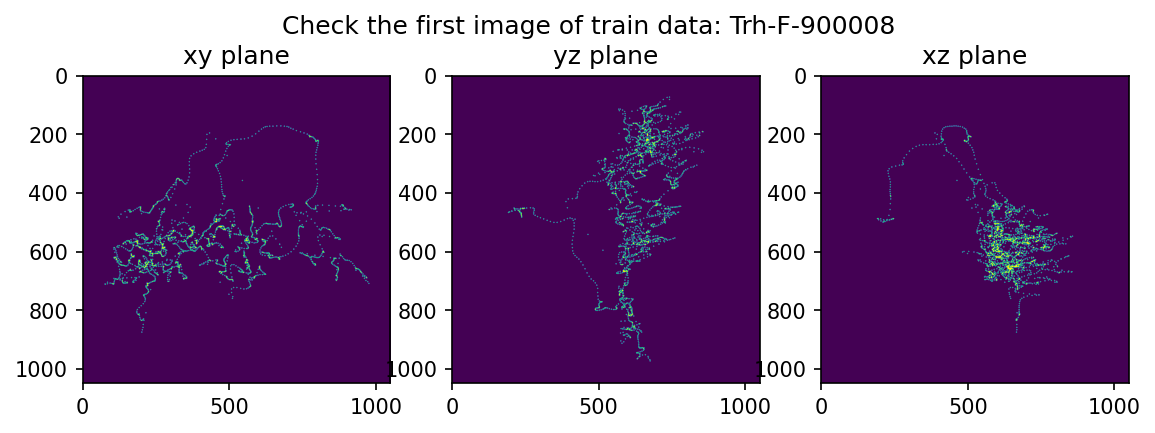

54

<Figure size 432x288 with 0 Axes>

In [8]:
# check for the first image
idname = id_train_df[0]
if use_dataset_train_proj:
    savepath = f"../input/3dto2d-preimage/train_3d"
    print("Using data set of projected training image")
    
else:
    savepath = f"./train_3d/"
    print("Rerun result")

fig = plt.figure(figsize=(9,3), dpi=150)
fig.suptitle(f"Check the first image of train data: {idname}")
plt.subplot(1,3,1)
plt.imshow(plt.imread(f"{savepath}/{idname}_xyplane.png"))
plt.title('xy plane')

plt.subplot(1,3,2)
plt.imshow(plt.imread(f"{savepath}/{idname}_yzplane.png"))
plt.title('yz plane')

plt.subplot(1,3,3)
plt.imshow(plt.imread(f"{savepath}/{idname}_xzplane.png"))
plt.title('xz plane')

plt.show()
plt.clf()
plt.close(fig)
gc.collect()

# 2. Pre-Processing the testing data (projection)

In [9]:
# set test data path and use test template.csv
path_test = '/kaggle/input/phys591000-2022-final-project-ii/fc_test_data/fc_test_data/'
df_test   = pd.read_csv('../input/phys591000-2022-final-project-ii/fc_prediction_template.csv')

id_test_df    = np.array(df_test['id'])

del df_test

## 2-1. interpolate the .swc file to get enough points (same as 1-1)

In [10]:
# using the function define in 1-1.

if not use_dataset_test_proj:
    print("Rerun cell")
    # swc_interp1d(path_file,id_file)
    dict_swc_test = swc_interp1d(path_test, id_test_df)

    with open(f"/kaggle/working/dict_swc_test.pickle", "wb") as f:
        pickle.dump(dict_swc_test,f)

    # del dict_swc_test
    # # using pickcle to load the .scw information
    # dict_swc = pickle.load(open("/kaggle/working/dict_swc.pickle", "rb"))
    
else:
    print("Using data set of projected test image, pass!")

Using data set of projected test image, pass!


## 2-2. generating the 2d projected .png from 3d .swc (same as 1-2)

In [11]:
# Then use swc_to_png function(define in 1-2.) to do projection of train data

if not use_dataset_test_proj:
    print("Rerun cell")
    # swc_to_png(dict_swc, id_file, folder_name)
    swc_to_png(dict_swc_test, id_test_df, 'test_3d')
    del dict_swc_test
    
else:
    print("Using data set of projected test image, pass!")

Using data set of projected test image, pass!


Using data set of projected test image!


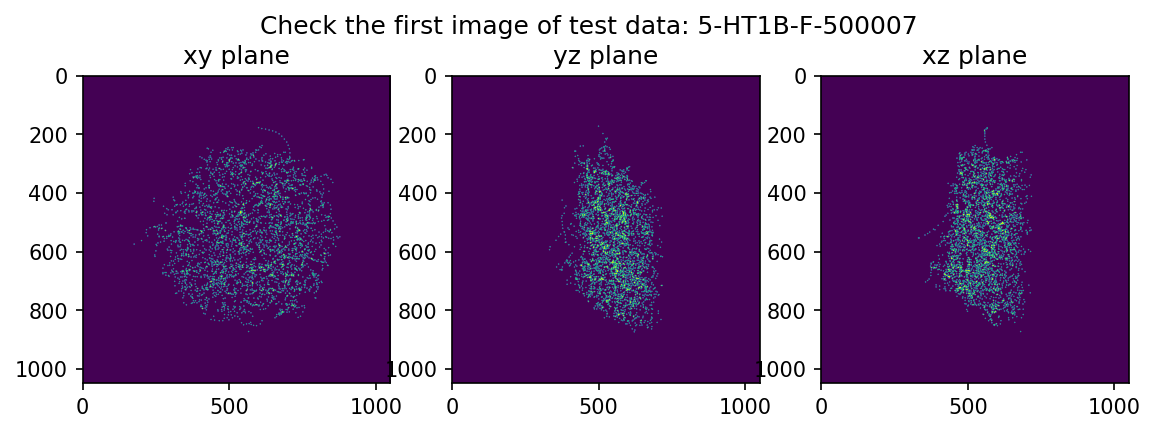

8013

<Figure size 432x288 with 0 Axes>

In [12]:
# check for the first image
idname = id_test_df[0]
if use_dataset_test_proj:
    savepath = f"../input/3dto2d-preimage/test_3d"
    print("Using data set of projected test image!")
    
else:
    savepath = f"./test_3d/"
    print("Rerun result")

fig = plt.figure(figsize=(9,3), dpi=150)
fig.suptitle(f"Check the first image of test data: {idname}")
plt.subplot(1,3,1)
plt.imshow(plt.imread(f"{savepath}/{idname}_xyplane.png"))
plt.title('xy plane')

plt.subplot(1,3,2)
plt.imshow(plt.imread(f"{savepath}/{idname}_yzplane.png"))
plt.title('yz plane')

plt.subplot(1,3,3)
plt.imshow(plt.imread(f"{savepath}/{idname}_xzplane.png"))
plt.title('xz plane')

plt.show()
plt.clf()
plt.close(fig)
gc.collect()

# 3. Processing the training data (resize image to CNN model)¶

## 3-1. Choose type 1 and 0 train images with number ratio (1.5:1)
Since the number of type 1 neurons are much more than type 0 (ratio 4:1),
we need to balance the number of two types to do model train.<br>
After trying different weights, we find that type1/0 with ratio 1.5:1 can get a better training.

In [13]:
if not use_dataset_CNN_model:
    # separate the id with label==1 and label==0
    id_train_type1 = id_train_df[label_train_df==1]
    id_train_type0 = id_train_df[label_train_df==0]

    # random slect the type1 image to let them have eqaul number of data as type0
    import random
    select         = random.sample(range(1207),int(293*1.5))
    id_train_type1 = id_train_type1[select]

    # training data id list and label list
    id_train    = np.hstack((id_train_type1,id_train_type0))
    label_train = np.hstack((np.ones(len(id_train_type1)), np.zeros(len(id_train_type0))))
    del id_train_type1, id_train_type0, select

And we have original 2D .png + projected xy/yz/xz 2D .png image, so the images numbers will be 4 times of original list.

In [14]:
if not use_dataset_CNN_model:
    id_train    = id_train[:,np.newaxis]
    label_train = label_train[:,np.newaxis]

    # random order the training data
    data = np.hstack((id_train,label_train))
    np.random.shuffle(data)

    id_train    = data[:,0]
    label_train = data[:,1]

    del data

    label_train = label_train.astype(int)
    label_train = np.eye(2)[label_train]

    # add the training data to 4 same list continue to the original one
    png_list   = np.hstack((id_train,id_train))
    y_train    = np.vstack((label_train,label_train))
    png_list   = np.hstack((png_list,id_train))
    y_train    = np.vstack((y_train,label_train))
    png_list   = np.hstack((png_list,id_train))
    y_train    = np.vstack((y_train,label_train))

## 3-2. Use cv2 to resize (1050,1050) -> (448,448) 
Loading those .png into (448,448) size with cv2 re-png-size package,
and remember to enlarger the signal(>0.01=threshold) to 1 and reduce other to 0

In [15]:
import glob
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

In [16]:
if not use_dataset_CNN_model:
    x_train = np.zeros((len(png_list),448,448), dtype=np.float16)

    path_train_png = '/kaggle/input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data/png/'
    
    if use_dataset_train_proj:
        project_train_png = "/kaggle/input/3dto2d-preimage/train_3d"
    else:
        project_train_png = "./train_3d"

    # original image
    for i in tqdm(range(0,len(id_train))):
        im = imageio.imread(path_train_png+png_list[i]+'.png')
        temp = np.array(im[:,:,1:2])
        x_train[i,:,:] = cv2.resize(temp, (448,448))/255.
        del im, temp
    print("Check - The final one image is:", png_list[i])

    # xy_plane image    
    for i in tqdm(range(0,len(id_train))):
        i = i+len(id_train)*1

        im = imageio.imread(f"{project_train_png}/{png_list[i]}_xyplane.png")
        x_train[i,:,:] = cv2.resize(im, (448,448))/255. 
        del im
    print("Check - The final one image is:", png_list[i])

    # yz_plane image
    for i in tqdm(range(0,len(id_train))):
        i = i+len(id_train)*2

        im = imageio.imread(f"{project_train_png}/{png_list[i]}_yzplane.png")
        x_train[i,:,:] = cv2.resize(im, (448,448))/255.
        del im
    print("Check - The final one image is:", png_list[i])

    # xz_plane image
    for i in tqdm(range(0,len(id_train))):
        i = i+len(id_train)*3

        im = imageio.imread(f"{project_train_png}/{png_list[i]}_xzplane.png")
        x_train[i,:,:] = cv2.resize(im, (448,448))/255
        del im
    print("Check - The final one image is:", png_list[i])

    x_train = x_train[:,:,:,np.newaxis]

In [17]:
# checking the enlarge effect of signal(>0.01) to 1 and remove other to 0

if not use_dataset_CNN_model:
    image_index = 0

    print("after enlarge signal")
    fig = plt.figure(figsize=(8,8), dpi=100)
    for i in [0,1,2,3]:
        plt.subplot(2,2,i+1)
        plt.imshow(x_train[len(id_train)*i+image_index,:,:])
    plt.show()
    plt.clf()
    plt.close(fig)

# 4. model training

In [18]:
if not use_dataset_CNN_model:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import *
    from tensorflow.keras.optimizers import SGD, Adadelta
    from tensorflow.keras import regularizers
    #from tensorflow.keras.callbacks import EarlyStopping
    #early_stopping = EarlyStopping(monitor="val_loss",min_delta=0.01,patience=50,mode="auto",baseline=None,restore_best_weights=False)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(1,1), strides=(1, 1), activation='relu', input_shape=(448,448,1)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64 , activation='relu'))
    model.add(Dense(16 , activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0)))
    model.add(Dropout(0.1))
    model.add(Dense(2  , activation='softmax'))

    model.compile(loss='binary_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])
    model.summary()
    # Train DNN model 
    # rec = model.fit(x_train, y_train, epochs=10, batch_size=15,verbose=1,validation_split=0.1)
    rec = model.fit(x_train, y_train, epochs=50, batch_size=15,verbose=1,validation_split=0.1)

    # Save model
    model.save('model_CNN.h5')

In [19]:
if not use_dataset_CNN_model:
    fig = plt.figure(dpi = 100)
    plt.plot(rec.history['accuracy'], lw=3, label='Train', color='blue')
    plt.plot(rec.history['val_accuracy'], lw=3, label='Validation', color='red')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.close('all')
    plt.clf()

    fig = plt.figure(dpi = 100)
    plt.plot(rec.history['loss'], lw=3, label='Train', color='blue')
    plt.plot(rec.history['val_loss'], lw=3, label='Validation', color='red')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close('all')
    plt.clf()
    gc.collect()

    del rec

In [20]:
if use_dataset_CNN_model:
    from tensorflow.keras.models import load_model
    print("loading model")
    model = load_model('../input/3dto2dcnnmodel/model_CNN.h5')
    print("loading finish")
    gc.collect()

loading model


2022-05-31 08:48:01.947401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 08:48:02.070891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 08:48:02.071779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 08:48:02.074144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

loading finish


# 5. Prediction of test data
In this part, we can get the first test data prediction of CNN model
## [Resize (1050,1050) -> (448,448)] + [prediction the test data]
In order to save the ram, we separate loading data into 4 parts:<br>
{1.original .png /<br> 2.xy plane .png /<br> 3.yz plane .png /<br> 4.xz plane .png}<br>
We predict them separatedly and get the average or 10 results of prediciton.
(also clear the ram when finish each part to save the ram)

In [21]:
# create the empty 1d array to save the prediction result
result_test  = np.zeros(len(id_test_df))

if use_dataset_test_proj:
    project_test_png = "/kaggle/input/3dto2d-preimage/test_3d"
else:
    project_test_png = "./test_3d"
    
def predict_cnn(id_df, path_png, filename, model, filetype):
    # create the empty 2d array to save the loading test data
    x = np.zeros((len(id_df),448,448))
    if filename == '.png':
        path_png = '../input/phys591000-2022-final-project-ii/fc_'+filetype+'_data/fc_'+filetype+'_data/png'
    
        for i in tqdm(range(0,len(id_df))):
            im = imageio.imread(f"{path_png}/{id_df[i]}{filename}")
            temp = np.array(im[:,:,1:2])
            x[i,:,:] = cv2.resize(temp, (448,448))/255.

            del im, temp

        x = x[:,:,:,np.newaxis]
        prediction_test = model.predict(x)[:,1]
        del x
        return prediction_test
    
    else:
        for i in tqdm(range(0,len(id_df))):
            im = imageio.imread(f"{path_png}/{id_df[i]}{filename}")
            x[i,:,:] = cv2.resize(im, (448,448))/255.

            del im

        x = x[:,:,:,np.newaxis]
        prediction_test = model.predict(x)[:,1]
        del x
        return prediction_test 
    
    
# original image
prediction_test = predict_cnn(id_test_df, project_test_png, '.png', model , 'test')
result_test  = result_test + prediction_test
del prediction_test


# xy_plane image  
prediction_test = predict_cnn(id_test_df, project_test_png, '_xyplane.png', model , 'test')
result_test  = result_test + prediction_test
del prediction_test


# yz_plane image
prediction_test = predict_cnn(id_test_df, project_test_png, '_yzplane.png', model , 'test')
result_test  = result_test + prediction_test
del prediction_test

# xz_plane image
prediction_test = predict_cnn(id_test_df, project_test_png, '_xzplane.png', model , 'test')
result_test  = result_test + prediction_test
del prediction_test

del project_test_png
gc.collect()

100%|██████████| 473/473 [00:33<00:00, 13.99it/s]
2022-05-31 08:49:04.255143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-31 08:49:05.267124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 473/473 [00:06<00:00, 76.50it/s]


3066

In [22]:
# get the average value of prediction
result_test_avg = result_test/4.
result_test_10  = np.zeros(len(id_test_df), dtype=np.int8)

# determine which one is prediction as 1 or 0 
for i in range(len(id_test_df)):
    
    if result_test_avg[i]<0.5 :
        result_test_10[i] = 0
    elif result_test_avg[i]>=0.5 :
        result_test_10[i] = 1
    else:
        print("something wrong")

In [23]:
np.save('test_prediciton_avg', result_test_avg)
np.save('test_prediciton_10', result_test_10)

d = {'id': id_test_df,
     'prediction': result_test_avg}
df = pd.DataFrame(data=d)

df.to_csv('result_CNN.csv', index=0)
del d, df, id_test_df, result_test, result_test_avg, result_test_10

# 6. Prediction of train data
In this part, we use the CNN model which is already trained to predict the training data.<br>
These predictions will be used by the XGBoost model in part 7.

## [Resize (1050,1050) -> (448,448)] + [prediction the test data]

In order to save the ram, we separate loading data into 4 parts:
{1.original .png /
2.xy plane .png /
3.yz plane .png /
4.xz plane .png}
We predict them separatedly and get the average or 10 results of prediciton. (also clear the ram when finish each part to save the ram)

***Remind that***:<br>
Beacause the **XGBoost model need all training data** instead of balance number of type1/0 data,
so we won't have the step of balance like part 3-1

In [24]:
# create the empty 1d array to save the predict result
result_train  = np.zeros(len(id_train_df))

if use_dataset_train_proj:
    project_train_png = "/kaggle/input/3dto2d-preimage/train_3d"
else:
    project_train_png = "./train_3d"
    
    
# original image
prediction_train = predict_cnn(id_train_df, project_train_png, '.png', model , 'train')
result_train  = result_train + prediction_train
del prediction_train


# xy_plane image  
prediction_train = predict_cnn(id_train_df, project_train_png, '_xyplane.png', model , 'train')
result_train  = result_train + prediction_train
del prediction_train


# yz_plane image
prediction_train = predict_cnn(id_train_df, project_train_png, '_yzplane.png', model , 'train')
result_train  = result_train + prediction_train
del prediction_train


# xz_plane image
prediction_train = predict_cnn(id_train_df, project_train_png, '_xzplane.png', model , 'train')
result_train  = result_train + prediction_train
del prediction_train

del project_train_png
gc.collect()

100%|██████████| 1500/1500 [01:32<00:00, 16.21it/s]
2022-05-31 08:51:11.912692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.
2022-05-31 08:51:13.278261: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.
100%|██████████| 1500/1500 [00:17<00:00, 88.21it/s]
2022-05-31 08:51:36.079135: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.
2022-05-31 08:51:37.690936: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.
100%|██████████| 1500/1500 [00:16<00:00, 90.90it/s]
2022-05-31 08:52:01.155264: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.
100%|██████████| 1500/1500 [00:17<00:00, 86.75it/s]


3068

In [25]:
# get the average value of prediction
result_train_avg = result_train/4.
result_train_10  = np.zeros(len(id_train_df), dtype=np.int8)

# determine which one is prediction as 1 or 0 
for i in range(len(id_train_df)):
    
    if result_train_avg[i]<0.5 :
        result_train_10[i] = 0
    elif result_train_avg[i]>=0.5 :
        result_train_10[i] = 1
    else:
        print("something wrong")
    
# check the correct rate 
correct = (label_train_df == result_train_10).sum()
print(f"The number of the same train result is:{correct}")
print(f"correct ratio of training data is:{(round(correct/len(id_train_df),4))*100}%")

The number of the same train result is:1433
correct ratio of training data is:95.53%


In [26]:
np.save('train_prediciton_avg', result_train_avg)
np.save('train_prediciton_10', result_train_10)

del model, label_train_df, result_train_avg, result_train_10, result_train, correct
gc.collect()

1421

# 7. Geometric features and 2d line plot

## 7.1 Import and install packages needed in this section

In [27]:
! pip install pylmeasure
! pip install ngauge
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylmeasure import *
import ngauge
import imageio
import skimage.io
import cv2
from io import BytesIO
import PIL
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.8 MB/s eta 0:00:00


## 7.2 Define data generator functions 

In [28]:
# generate train and test files' path 
def generate_filepath(path,files):
    swcFiles = []
    for file in files:
        swcFiles.append(path+file+'.swc')
    return swcFiles

#L-Measure generate features
def generate_features(swcFiles):
    #Select the feature function that we want to apply into trainging
    support_list = ['Length', 'EucDistance', 'PathDistance', 'Terminal_degree', 'Branch_pathlength', 'Contraction', 'Fragmentation', 'Partition_asymmetry', 'Bif_ampl_local', 'Bif_ampl_remote', 'Bif_tilt_local', 'Bif_tilt_remote', 'Helix', 'Fractal_Dim']
    LMOutput  = getMeasure(support_list, swcFiles)
    data = np.zeros((len(swcFiles),57))
    number_type = ["TotalSum","Minimum","Average","Maximum","StdDev"]
    choose = [[0,2,3,4],
              [0,2,3,4],
              [0,2,3,4],
              [0,2,3,4],
              [0,2,3,4],
              [0,1,2,4],
              [0,2,3,4],
              [0,2,4],
              [0,1,2,3,4],
              [0,1,2,3,4],
              [0,1,2,3,4],
              [0,1,2,3,4],
              [0,2,4],
              [2,3,4]]
    for i in tqdm(range(len(swcFiles))):
        k = 0
        for j in range(len(support_list)):
            for tick in choose[j]:
                data[i,k] = LMOutput[j]["WholeCellMeasuresDict"][i][number_type[tick]]
                k += 1
    return data

#nGuage generate figures 128*128*3
def make_fig(swcFiles):
    x_train = np.zeros((len(swcFiles),128,128,3))
    x_train = x_train.astype(int)

    fig = plt.figure(figsize=(32, 32), dpi=4)

    for i in tqdm(range(len(swcFiles))):
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")

        neuron = ngauge.Neuron.from_swc(swcFiles[i])
        fig = neuron.plot(fig=fig, ax=ax, axis="x", color=(0, 0, 0)) #nGuage function: plot the neuron line plot project along x axis 
        ax = fig.get_axes()[0]
        ax.axis('off')

        buffer_ = BytesIO() # Use the ram as the buffer to store the figure 
        plt.savefig(buffer_,format = 'png')
        buffer_.seek(0)
        dataPIL = PIL.Image.open(buffer_).convert('L')
        data = np.ceil((np.asarray(dataPIL)/255*-1)+1) #Nolmalize the matric after loding from PIL
        x_train[i,:,:,0] = data.astype(int) # reduce the data size (since the data would only be 1 or 0)
        buffer_.close()
        plt.clf()

        ax = fig.add_subplot(111)
        ax.set_aspect("equal")

        fig = neuron.plot(fig=fig, ax=ax, axis="y", color=(0, 0, 0)) #nGuage function: plot the neuron line plot project along y axis 
        ax = fig.get_axes()[0]
        ax.axis('off')

        buffer_ = BytesIO() # Use the ram as the buffer to store the figure 
        plt.savefig(buffer_,format = 'png')
        buffer_.seek(0)
        dataPIL = PIL.Image.open(buffer_).convert('L')
        data = np.ceil((np.asarray(dataPIL)/255*-1)+1) #Nolmalize the matric after loding from PIL
        x_train[i,:,:,1] = data.astype(int) # reduce the data size (since the data would only be 1 or 0)
        buffer_.close()
        plt.clf()

        ax = fig.add_subplot(111)
        ax.set_aspect("equal")

        fig = neuron.plot(fig=fig, ax=ax, axis="z", color=(0, 0, 0)) #nGuage function: plot the neuron line plot project along z axis 
        ax = fig.get_axes()[0]
        ax.axis('off')

        buffer_ = BytesIO() # Use the ram as the buffer to store the figure 
        plt.savefig(buffer_,format = 'png')
        buffer_.seek(0)
        dataPIL = PIL.Image.open(buffer_).convert('L') 
        data = np.ceil((np.asarray(dataPIL)/255*-1)+1) #Nolmalize the matric after loding from PIL
        x_train[i,:,:,2] = data.astype(int) # reduce the data size (since the data would only be 1 or 0)
        buffer_.close()
        plt.clf()
    return x_train

## 7.3 Read scv files and save the features and figures

In [29]:
df = pd.read_csv("../input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data/fc_training_list.csv")
path = '../input/phys591000-2022-final-project-ii/fc_train_data/fc_train_data/swc/'
y_train      = np.array(df['label'])
np.save('y_train.npy',y_train)

x_train_file = np.array(df['id'])
x_train_feature  = generate_features(generate_filepath(path,x_train_file))
x_train_figure   = make_fig(generate_filepath(path,x_train_file))
np.save('x_train.npy',x_train_feature)
np.save('x_train_fig.npy',x_train_figure)

df = pd.read_csv("../input/phys591000-2022-final-project-ii/fc_prediction_template.csv")
path = '../input/phys591000-2022-final-project-ii/fc_test_data/fc_test_data/swc/'

x_test_file = np.array(df['id'])
x_test_feature  = generate_features(generate_filepath(path,x_test_file))
x_test_figure   = make_fig(generate_filepath(path,x_test_file))
np.save('x_test.npy',x_test_feature)
np.save('x_test_fig.npy',x_test_figure)

100%|██████████| 473/473 [01:44<00:00,  4.54it/s]


<Figure size 128x128 with 0 Axes>

<Figure size 128x128 with 0 Axes>

# 8. ResNet50 network figure classification

## 8.1 Import packages needed in this section

In [30]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adadelta
import numpy as np
import pandas as pd 
import random

## 8.2 Define the data generator function
Since the number of type 1 neurons are much more than type 0 (ratio 4:1),
we need to balance the number of two types to do model train.<br>
After trying different weights, we find that type1/0 with ratio 1.5:1 can get a better training.

In [31]:
def prepare_training_data(use_dataset_Res_model):
    # load data
    if use_dataset_Res_model:
        x_train0 = np.load('../input/data-preprocess-2/x_train_fig.npy')
        y_train0 = np.load('../input/data-preprocess-2/y_train.npy')
        x_test   = np.load('../input/data-preprocess-2/x_test_img_pred.npy')
    else:
        x_train0 = np.load('./x_train_fig.npy')
        y_train0 = np.load('./y_train.npy')
        x_test   = np.load('./x_test_img_pred.npy')

    #data balance
    type0_data = x_train0[y_train0 == 0]
    type1_data = x_train0[y_train0 == 1]
    type0_y    = y_train0[y_train0 == 0]
    type1_y    = y_train0[y_train0 == 1]

    random.seed(1)
    select = random.sample(range(1207),int(293*1.5))
    type1_data = type1_data[select]
    type1_y    = type1_y[select]

    x_train_pre = np.vstack((type0_data,type1_data))
    y_train_pre = np.hstack((type0_y,type1_y))

    num = np.array(list(range(len(x_train_pre))))
    random.seed(1)
    np.random.shuffle(num)

    x_train = x_train_pre[num]
    y_train = y_train_pre[num]
    y_train = y_train.astype(int)
    y_train  = np.eye(2)[y_train] # label to one-hot
    
    return x_train,y_train

## 8.3 Training the ResNet model

In [32]:
x_train,y_train = prepare_training_data(use_dataset_Res_model)
num_classes = 2
input_shape = (128, 128, 3)
resMod = ResNet50(include_top=True, weights=None, input_shape=input_shape, classes=num_classes)
resMod.compile(loss='binary_crossentropy',optimizer=Adadelta(),metrics=['accuracy'])
rec = resMod.fit(x_train, y_train, epochs=85, batch_size=50,verbose=2,validation_split=0.1)
resMod.save('ResNet50.h5')

Epoch 1/85
14/14 - 9s - loss: 0.7150 - accuracy: 0.5410 - val_loss: 0.7001 - val_accuracy: 0.3108
Epoch 2/85
14/14 - 1s - loss: 0.6256 - accuracy: 0.7021 - val_loss: 0.6972 - val_accuracy: 0.3108
Epoch 3/85
14/14 - 1s - loss: 0.5452 - accuracy: 0.7796 - val_loss: 0.6871 - val_accuracy: 0.6892
Epoch 4/85
14/14 - 1s - loss: 0.4934 - accuracy: 0.8252 - val_loss: 0.6729 - val_accuracy: 0.6892
Epoch 5/85
14/14 - 1s - loss: 0.4720 - accuracy: 0.8328 - val_loss: 0.6564 - val_accuracy: 0.6892
Epoch 6/85
14/14 - 2s - loss: 0.4422 - accuracy: 0.8556 - val_loss: 0.6407 - val_accuracy: 0.6892
Epoch 7/85
14/14 - 1s - loss: 0.4210 - accuracy: 0.8526 - val_loss: 0.6288 - val_accuracy: 0.6892
Epoch 8/85
14/14 - 1s - loss: 0.4046 - accuracy: 0.8632 - val_loss: 0.6224 - val_accuracy: 0.6892
Epoch 9/85
14/14 - 1s - loss: 0.3926 - accuracy: 0.8663 - val_loss: 0.6225 - val_accuracy: 0.6892
Epoch 10/85
14/14 - 1s - loss: 0.3964 - accuracy: 0.8617 - val_loss: 0.6286 - val_accuracy: 0.6892
Epoch 11/85
14/14 -

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## 8.4 Output the final prediction result

In [33]:
x_train  = np.load('../input/data-preprocess-2/x_train_fig.npy')
x_test   = np.load('../input/data-preprocess-2/x_test_fig.npy')

x_train_pred = resMod.predict(x_train)
x_test_pred  = resMod.predict(x_test)

np.save('x_train_img_pred.npy',x_train_pred)
np.save('x_test_img_pred.npy',x_test_pred)

# 9. XGBoost+CV

## 9.1 import packages needed in this section

In [34]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import xgboost
import random

## 9.2 Define the data generator function
Here, we use the data from all the process above, including the image classifiction(CNN,ResNet50) and the geometric features

Since the number of type 1 neurons are much more than type 0 (ratio 4:1),
we need to balance the number of two types to do model train.<br>
After trying different weights, we find that type1/0 with ratio 1.5:1 can get a better training.

In [35]:
def prepare_data(use_dataset_XGB_model):
    if use_dataset_XGB_model:
        x_train = np.load('../input/data-preprocess-2/x_train.npy')
        y_train = np.load('../input/data-preprocess-2/y_train.npy')
        x_test  = np.load('../input/data-preprocess-2/x_test.npy')
        
        x_train_img = np.load('../input/data-preprocess-2/train_prediciton_origianl.npy')
        x_test_img  = np.load('../input/data-preprocess-2/test_prediciton_origianl.npy')

        x_train_img1 = np.load('../input/data-preprocess-2/x_train_img_pred.npy')
        x_test_img1  = np.load('../input/data-preprocess-2/x_test_img_pred.npy')
    else:
        x_train = np.load('./x_train.npy')
        y_train = np.load('./y_train.npy')
        x_test  = np.load('./x_test.npy')

        x_train_img = np.load('./train_prediciton_origianl.npy')
        x_test_img  = np.load('./test_prediciton_origianl.npy')

        x_train_img1 = np.load('./x_train_img_pred.npy')
        x_test_img1  = np.load('./x_test_img_pred.npy')

    x_train_img = x_train_img[:,np.newaxis]
    x_test_img  = x_test_img[:,np.newaxis]

    x_train_img1 = x_train_img1[:,0:1]
    x_test_img1  = x_test_img1[:,0:1]

    x_train = np.hstack((x_train, x_train_img, x_train_img1))
    x_test  = np.hstack((x_test, x_test_img, x_test_img1))

    type0_data = x_train[y_train == 0]
    type1_data = x_train[y_train == 1]
    type0_y    = y_train[y_train == 0]
    type1_y    = y_train[y_train == 1]

    random.seed(7)
    select = random.sample(range(1207),int(293*1.5))

    select_list = np.zeros(len(type1_data)).astype(bool)
    select_list[select] = True

    #type1_data_n = type1_data[np.logical_not(select_list)]
    #type1_y_n    = type1_y[np.logical_not(select_list)]

    type1_data = type1_data[select]
    type1_y    = type1_y[select]

    x_train_pre = np.vstack((type0_data,type1_data))
    y_train_pre = np.vstack((type0_y[:,np.newaxis],type1_y[:,np.newaxis]))

    train_data_pre = np.hstack((x_train_pre,y_train_pre))
    np.random.seed(3)
    np.random.shuffle(train_data_pre)

    x_train1 = train_data_pre[:,:-1]
    y_train1 = train_data_pre[:,-1]

    y_train1  = y_train1.astype(int) 
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(x_train1, y_train1, test_size =0.4, random_state=0)
    
    return X_train, X_valid, Y_train, Y_valid, x_test

## 9.3 Training the Xgboost model

In [36]:
X_train, X_valid, Y_train, Y_valid, x_test = prepare_data(use_dataset_XGB_model)
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
params['max_depth'] = 3
params['learning_rate'] = 0.01

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 2000, watchlist, early_stopping_rounds=20, verbose_eval=100)
bst.save_model('bst.json')

[0]	train-logloss:0.68407	valid-logloss:0.68409


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[100]	train-logloss:0.23140	valid-logloss:0.23951
[200]	train-logloss:0.09828	valid-logloss:0.11608
[300]	train-logloss:0.04957	valid-logloss:0.07269
[400]	train-logloss:0.02959	valid-logloss:0.05501
[500]	train-logloss:0.02050	valid-logloss:0.04722
[600]	train-logloss:0.01546	valid-logloss:0.04366
[700]	train-logloss:0.01276	valid-logloss:0.04116
[800]	train-logloss:0.01088	valid-logloss:0.03927
[900]	train-logloss:0.00979	valid-logloss:0.03858
[1000]	train-logloss:0.00910	valid-logloss:0.03779
[1100]	train-logloss:0.00847	valid-logloss:0.03713
[1200]	train-logloss:0.00801	valid-logloss:0.03656
[1300]	train-logloss:0.00770	valid-logloss:0.03617
[1400]	train-logloss:0.00743	valid-logloss:0.03587
[1500]	train-logloss:0.00718	valid-logloss:0.03554
[1600]	train-logloss:0.00695	valid-logloss:0.03525
[1700]	train-logloss:0.00675	valid-logloss:0.03494
[1800]	train-logloss:0.00655	valid-logloss:0.03468
[1900]	train-logloss:0.00637	valid-logloss:0.03447
[1999]	train-logloss:0.00621	valid-loglo

## 9.4 Output the final prediction result

In [37]:
df = pd.read_csv("../input/phys591000-2022-final-project-ii/fc_prediction_template.csv")
files = np.array(df['id'])

output = bst.predict(xgboost.DMatrix(x_test))

df = pd.DataFrame()
df['id'] = pd.DataFrame(files)
df['prediction'] = pd.DataFrame(output)
df.to_csv('submission.csv', index=0)